In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

%pwd

/home/ubuntu/.conda/envs/mmlab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.1 True
1.0.0rc5


'/home/ubuntu/mmsegmentation'

# Add the dataset

In [2]:
# define dataset root and directory for images and annotations
data_root = 'data/IonoSeg'
img_dir = 'rgbimg'
ann_dir = 'rgbmask'
catogory_id_dir = 'label'
# define class and palette for better visualization
classes = ('Background', 'E', 'Es-l', 'Es-c', 'F1', 'F2', 'Spread-F')
palette = [[230, 230, 230], [250, 165, 30], [120, 69, 125], [53, 125, 34],
           [0, 11, 123], [130, 20, 12], [120, 121, 80]]    

Take a glance at the data

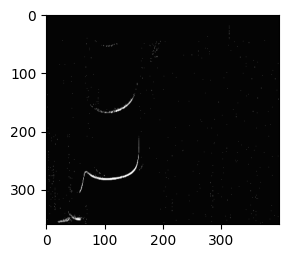

In [3]:
import mmcv
import matplotlib.pyplot as plt
import os.path as osp

img = mmcv.imread(osp.join(data_root, img_dir, '20191031101500.png'))
plt.figure(figsize=(3, 3))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [4]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class IonogramSegmentationDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

Create config file

In [5]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')

In [6]:
cfg.data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[5.45, 5.45, 5.45],
    std=[13.12, 13.12, 13.12],
    bgr_to_rgb=False,
    pad_val=0,
    seg_pad_val=255,
    size=cfg.crop_size)

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (512, 512)
cfg.model.data_preprocessor = cfg.data_preprocessor
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# Class Balanced Loss
cfg.model.decode_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, class_weight=[0.2, 1.4, 4, 6, 2, 1, 2])
cfg.model.auxiliary_head.loss_decode = dict(type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4, class_weight=[0.2, 1.4, 4, 6, 2, 1, 2])

cfg.optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=dict(type='SGD', lr=2e-4, momentum=0.9, weight_decay=0.0005),
    clip_grad=None)

cfg.param_scheduler = [
    dict(
        type='PolyLR',
        eta_min=1e-4,
        power=0.9,
        begin=0,
        end=10,
        by_epoch=False)
]

# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 7
cfg.model.auxiliary_head.num_classes = 7

# Modify dataset type and path
cfg.dataset_type = 'IonogramSegmentationDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(360, 400), keep_ratio=True),
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]
img_ratios = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
cfg.tta_pipeline = [
    dict(type='LoadImageFromFile', backend_args=dict(backend='local')),
    dict(
        type='TestTimeAug',
        transforms=[
            [
                dict(type='Resize', scale_factor=r, keep_ratio=True)
                for r in img_ratios
            ],
            [
                dict(type='RandomFlip', prob=0., direction='horizontal'),
                dict(type='RandomFlip', prob=1., direction='horizontal')
            ], 
            [dict(type='LoadAnnotations')],
            [dict(type='PackSegInputs')]
        ]
    )
]

cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits0/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits0/val.txt'

cfg.test_dataloader = cfg.val_dataloader
cfg.test_dataloader.dataset.ann_file = 'splits0/test.txt'

# Load the pretrained weights
cfg.load_from = '/home/ubuntu/mmsegmentation/work_dirs/se4ionogram/pspnet_r50_ionogram_iou_3922_acc_9153.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/seg_finetune'

cfg.default_hooks = dict(
    timer=dict(type='IterTimerHook'),
    logger=dict(type='LoggerHook', interval=100, log_metric_by_epoch=False),
    param_scheduler=dict(type='ParamSchedulerHook'),
    checkpoint=dict(type='CheckpointHook', by_epoch=False, interval=10),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    visualization=dict(type='SegVisualizationHook'))

cfg.train_cfg.max_iters = 10
cfg.train_cfg.val_interval = 10

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

Config.dump(cfg, './configs/_se4ionogram/pspnet_r50_ionogram_mmseg1.py')

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[5.45, 5.45, 5.45],
    std=[13.12, 13.12, 13.12],
    bgr_to_rgb=False,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[5.45, 5.45, 5.45],
        std=[13.12, 13.12, 13.12],
        bgr_to_rgb=False,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 1024)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
 

# Train and evaluate

In [7]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

02/12 22:38:47 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Jan 17 2023, 23:13:24) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla V100-SXM2-32GB
    CUDA_HOME: :/usr/local/cuda-11.4
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.12.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute

/home/ubuntu/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/ubuntu/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/ubuntu/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


02/12 22:38:49 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/12 22:38:49 - mmengine - WARNING - The "hook" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 22:38:49 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook  

/home/ubuntu/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [8]:
# start training
runner.train()

02/12 22:38:50 - mmengine - WARNING - The "loop" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 22:38:50 - mmengine - WARNING - The "dataset" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 22:38:50 - mmengine - WARNING - The "transform" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 22:38:50 - mmengine - WARNING - The "data sampler" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 22:38:50 - mmengine - WARNING - The "optimizer wrapper constructor" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 22:38:50 - mmengine - WARNING - The "optimizer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 22:38:

/home/ubuntu/.conda/envs/mmlab/lib/python3.8/site-packages/mmengine/evaluator/metric.py:47: UserWarning: The prefix is not set in metric class IoUMetric.
  warnings.warn('The prefix is not set in metric class '


02/12 22:38:51 - mmengine - WARNING - The "weight initializer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
02/12 22:38:51 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
02/12 22:38:51 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
02/12 22:38:51 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: /home/ubuntu/mmsegmentation/work_dirs/se4ionogram/pspnet_r50_ionogram_iou_3922_acc_9153.pth
02/12 22:38:51 - mmengine - INFO - Load checkpoint from /home/ubuntu/mmsegmentation/work_dirs/se4ionogram/pspnet_r50_ionogram_iou_3922_acc_9153.pth
02/12 22:38:51 - mmengine - INFO - Checkpoints will be saved to /home/ubuntu/mmsegmentation/work_dirs/seg_finetune.
02/12 22:39:18 - mmengine - INFO - Saving checkpoint at 10 iterations
02/12 22:39:25 - mmen

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

Loads checkpoint by local backend from path: ./work_dirs/seg_finetune/iter_10.pth


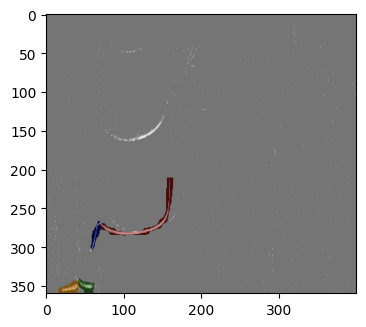

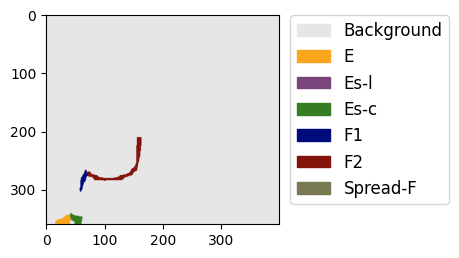

In [34]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/seg_finetune/iter_10.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread(osp.join(data_root, img_dir, '20191031101500.png'))
result = inference_model(model, img)
plt.figure(figsize=(4, 4))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(vis_result)

plt.figure(figsize=(3, 3))
# draw the legend
seg_res = Image.fromarray(np.uint8(result.pred_sem_seg.data.cpu().squeeze(0).numpy())).convert('P')
seg_res.putpalette(np.array(palette, dtype=np.uint8))
im = plt.imshow(np.array(seg_res.convert('RGB')))
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255.,label=classes[i]) for i in range(7)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize='large')
plt.show()